In [4]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
feature = pd.read_csv('Fixed_data.csv', converters={'Ethnicity': str.strip})
feature.head(5)

,Code,Area,Year,Sex,Ethnicity,Pupils,Attainment8,Progress8
0,E09000002,Barking and Dagenham,2018/19,All,White,903.0,41.7,-0.21
1,E09000002,Barking and Dagenham,2018/19,All,Mixed,227.0,44.7,0.05
2,E09000002,Barking and Dagenham,2018/19,All,Asian,530.0,53.3,0.60
3,E09000002,Barking and Dagenham,2018/19,All,Black,642.0,48.0,0.37
4,E09000002,Barking and Dagenham,2018/19,All,Chinese,3.0,69.0,0.93


In [5]:
feature['Pupils'] = feature['Pupils'].fillna(feature['Pupils'].mean())
feature['Attainment8'] = feature['Attainment8'].fillna(feature['Attainment8'].mean())
feature['Progress8'] = feature['Progress8'].fillna(feature['Progress8'].mean())

In [6]:
feature.isnull().sum()

Code           0
Area           0
Year           0
Sex            0
Ethnicity      0
Pupils         0
Attainment8    0
Progress8      0
dtype: int64

In [7]:
print('The shape of our features is:', feature.shape)

The shape of our features is: (3240, 8)


In [8]:
feature.describe()

,Pupils,Attainment8,Progress8
count,3240.000000,3240.000000,3240.000000
mean,6146.238585,52.011719,0.285722
std,30185.585452,7.607603,0.417303
min,1.000000,15.000000,-0.860000
25%,131.750000,47.000000,0.010000
50%,450.000000,50.800000,0.270000
75%,1766.750000,54.900000,0.510000
max,540006.000000,89.000000,2.820000


In [9]:
features = feature.drop(columns='Code')

In [10]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)
# Display the first 5 rows of the last 12 columns
features.iloc[:,5:].head(5)

,Area_Bexley,Area_Brent,Area_Bromley,Area_Camden,Area_City of London,Area_Croydon,Area_Ealing,Area_East,Area_East Midlands,Area_Enfield,...,Year_2018/19,Sex_All,Sex_Boys,Sex_Girls,Ethnicity_All Pupils,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Chinese,Ethnicity_Mixed,Ethnicity_White
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0


In [11]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(features['Attainment8'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('Attainment8', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [12]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2430, 60)
Training Labels Shape: (2430,)
Testing Features Shape: (810, 60)
Testing Labels Shape: (810,)


In [30]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('Progress8')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  51.58


In [18]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [19]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.77


In [20]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 96.38 %.


In [21]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [22]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [23]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Ethnicity_Chinese    Importance: 0.45
Variable: Progress8            Importance: 0.27
Variable: Pupils               Importance: 0.05
Variable: Year_2015/16         Importance: 0.03
Variable: Ethnicity_Black      Importance: 0.03
Variable: Area_Sutton          Importance: 0.02
Variable: Area_Barnet          Importance: 0.01
Variable: Area_Bexley          Importance: 0.01
Variable: Area_Bromley         Importance: 0.01
Variable: Area_Kensington and Chelsea Importance: 0.01
Variable: Area_Kingston upon Thames Importance: 0.01
Variable: Area_Waltham Forest  Importance: 0.01
Variable: Year_2018/19         Importance: 0.01
Variable: Sex_Boys             Importance: 0.01
Variable: Sex_Girls            Importance: 0.01
Variable: Area_Barking and Dagenham Importance: 0.0
Variable: Area_Brent           Importance: 0.0
Variable: Area_Camden          Importance: 0.0
Variable: Area_City of London  Importance: 0.0
Variable: Area_Croydon         Importance: 0.0
Variable: Area_Ealing       

In [24]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('Ethnicity_Chinese'), feature_list.index('Progress8')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.23
Accuracy: 93.59 %.


In [25]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('Ethnicity_Black'), feature_list.index('Progress8')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.49
Accuracy: 93.32 %.


In [26]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('Ethnicity_Mixed'), feature_list.index('Progress8')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.66
Accuracy: 92.95 %.


In [27]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('Ethnicity_White'), feature_list.index('Progress8')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.74
Accuracy: 92.78 %.


In [28]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('Ethnicity_Asian'), feature_list.index('Progress8')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2))
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.69
Accuracy: 92.86 %.


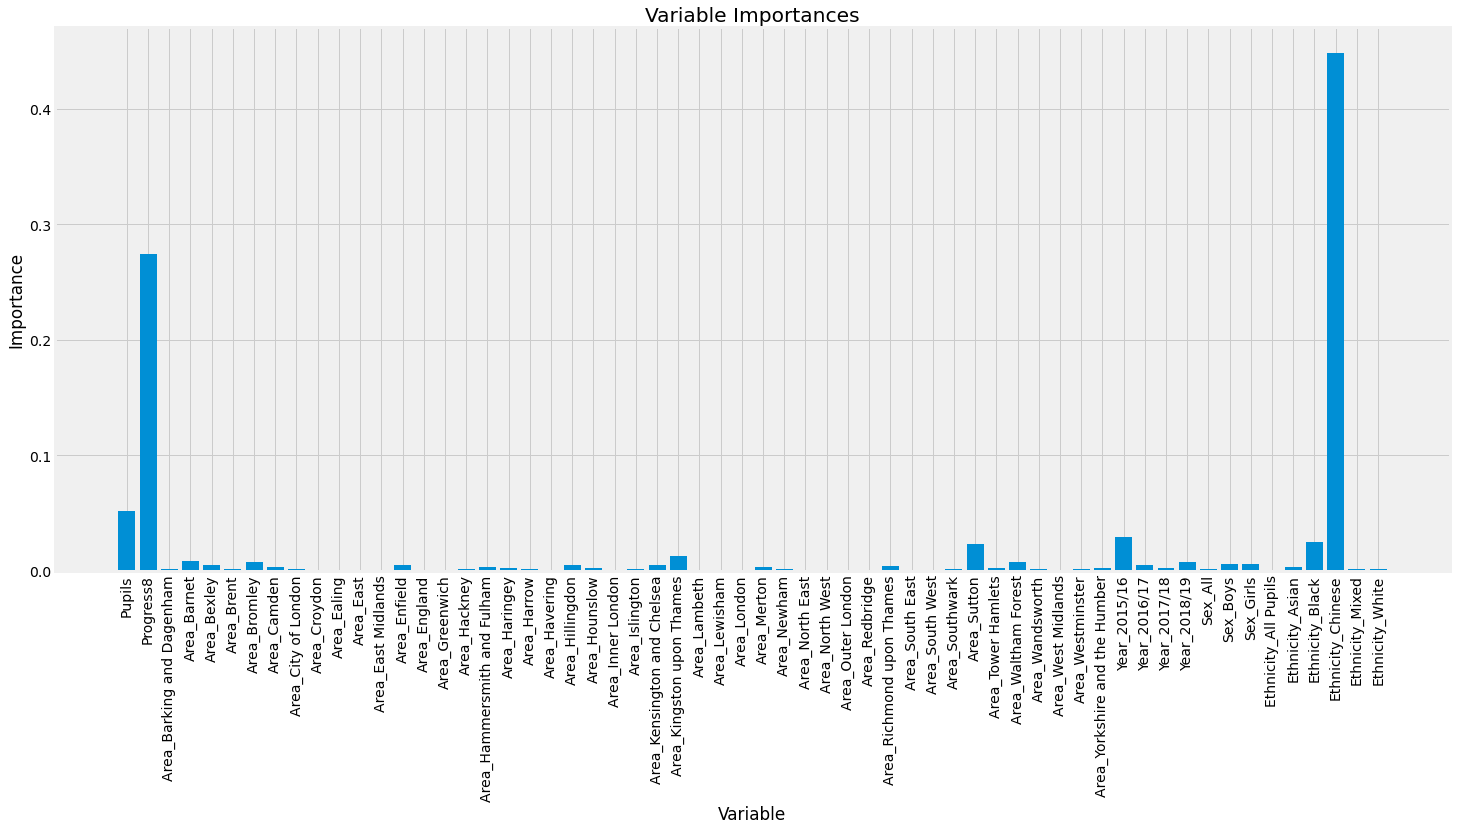

In [29]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(25 ,10))
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');